In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.4.1


NIH chest x-ray data

In [3]:
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
#np.set_printoptions(threshold=np.inf)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

process_data.py


import os
import shutil  #high-level file operations like copying a file
import random

seed = 1
random.seed(seed)

train = "data/balanced_set_normal_Pneumonia/train/"
test = "data/balanced_set_normal_Pneumonia/test/"
validation = "data/balanced_set_normal_Pneumonia/validation/"

os.makedirs(train + "normal/")
os.makedirs(train + "pneumonia/")
os.makedirs(test + "normal/")
os.makedirs(test + "pneumonia/")
os.makedirs(validation + "normal/")
os.makedirs(validation + "pneumonia/")

test_examples = train_examples = validation_examples = 0


for i in range(1, 13):
    directory = "data/images_" + str(i) + "/"
    print(directory)

    for line in open("data/Data_Entry_2017_v2020_normal_Pneumonia_only.csv").readlines()[1:]:
        split_line = line.split(",")
        img_file = split_line[0]
        normal_pneumonia = split_line[1]

        #if os.path.isfile("data/images_001/" + img_file):
        if os.path.isfile(directory + img_file):
            random_num = random.random()

            if random_num <0.8:
                location = train
                train_examples += 1
            elif random_num <0.9:
                location = validation
                validation_examples += 1
            else: 
                location = test
                test_examples += 1
            #print(normal_pneumonia)
            if normal_pneumonia == "Pneumonia":
            #if 'Pneumonia' in normal_pneumonia:
                shutil.copy(
                    directory + img_file,
                    location + "pneumonia/" + img_file,
                )
            #elif 'Pneumonia' not in normal_pneumonia:
            #    print('not in')
            elif normal_pneumonia == "No Finding":
                shutil.copy(
                    directory + img_file,
                    location + "normal/" + img_file,
                )

print(f"Number of training examples {train_examples}")
print(f"Number of test examples {test_examples}")
print(f"Number of validation examples {validation_examples}")
    

In [5]:
train = "data/balanced_set_normal_Pneumonia/train/"
test = "data/balanced_set_normal_Pneumonia/test/"
validation = "data/balanced_set_normal_Pneumonia/validation/"


reduce number of samples for "normal" by randomly selecet small number of samples

In [6]:
# dirpath = "data/validation/non_pneumonia/"
# destDirectory = "data/balanced_set/validation/non_pneumonia/"
# filenames = random.sample(os.listdir(dirpath), 150)
# for fname in filenames:
#     srcpath = os.path.join(dirpath, fname)
#     shutil.copy(srcpath, destDirectory)

In [7]:
# import os
# import shutil  #high-level file operations like copying a file
# import random
# source_dir = train + "normal/"
# dest_dir = train + "normal_downsampling/"
# #os.makedirs(dest_dir)
# filenames = random.sample(os.listdir(source_dir), 512)
# for fname in filenames:
#     srcpath = os.path.join(source_dir, fname)
#     shutil.copy(srcpath, dest_dir)

use data augmentation for train data only to prevent overfitting

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 18,
    zoom_range = (0.92, 0.92),
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    horizontal_flip = False,
    #vertical_flip = True,
    data_format = "channels_last",
    dtype = tf.float32,
)

validation_datagen = ImageDataGenerator(rescale=1.0/255, dtype=tf.float32)
test_datagen = ImageDataGenerator(rescale=1.0/255, dtype=tf.float32)


In [9]:
img_height = 224
img_width = 224
batch_size = 32


In [10]:
train_gen = train_datagen.flow_from_directory(
    train,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    seed = 123,
)
validation_gen = validation_datagen.flow_from_directory(
    validation,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = True,
    seed = 123,
)
test_gen = test_datagen.flow_from_directory(
    test,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "binary",
    shuffle = False,
    seed = 123,
)

Found 2512 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


In [11]:
train_examples = train_gen.samples 
validation_examples = validation_gen.samples 
test_examples = test_gen.samples 

print(f"Number of training examples {train_examples}") 
print(f"Number of validation examples {validation_examples}")
print(f"Number of test examples {test_examples}") 

train_image_normal_count = len(os.listdir('data/balanced_set_normal_Pneumonia/train/normal'))
train_image_pneumonia_count = len(os.listdir('data/balanced_set_normal_Pneumonia/train/pneumonia'))
validation_image_normal_count = len(os.listdir('data/balanced_set_normal_Pneumonia/validation/normal'))
validation_image_pneumonia_count = len(os.listdir('data/balanced_set_normal_Pneumonia/validation/pneumonia'))
test_image_normal_count = len(os.listdir('data/balanced_set_normal_Pneumonia/test/normal'))
test_image_pneumonia_count = len(os.listdir('data/balanced_set_normal_Pneumonia/test/pneumonia'))

print(f"train_image_normal_count {train_image_normal_count}")
print(f"train_image_pneumonia_count {train_image_pneumonia_count}")

ratio = train_image_pneumonia_count / train_image_normal_count
print(ratio)
initial_bias = np.log(train_image_pneumonia_count/train_image_normal_count)
print(initial_bias)

Number of training examples 2512
Number of validation examples 237
Number of test examples 209
train_image_normal_count 2000
train_image_pneumonia_count 512
0.256
-1.3625778345025745


In [12]:
# def plotImages(images_arr, labels):
#     fig, axes = plt.subplots(1, 10, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

In [13]:
def plotImages(imgs, labels):
    plt.figure(figsize=(12,12))
    plt.tight_layout()

    for n in range(batch_size):
        ax = plt.subplot(6,6,n+1)
        plt.imshow(imgs[n])
        if labels[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
    plt.show()

In [14]:
imgs, labels = next(train_gen)

Train labels: [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0.]


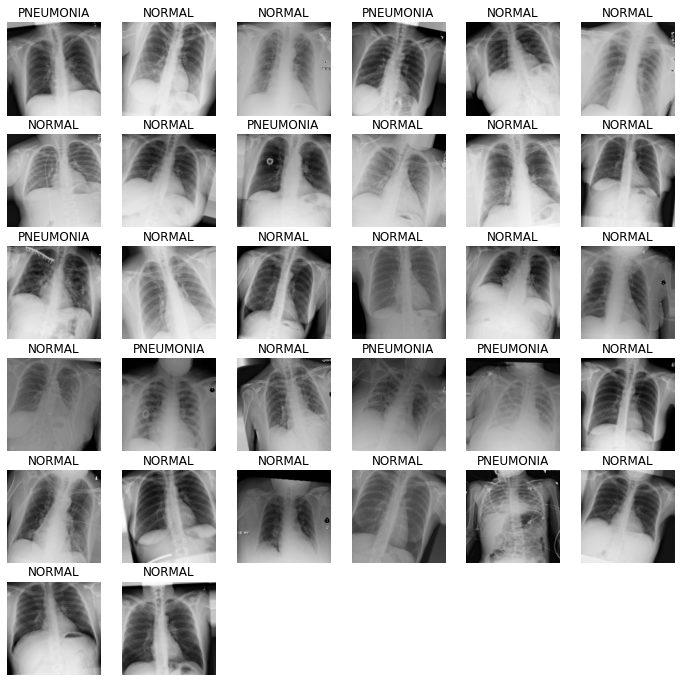

In [15]:
print(f"Train labels: {labels}")
plotImages(imgs, labels)



In [16]:
imgs, labels = next(test_gen)
print(f"Test labels: {labels}")0
plotImages(imgs, labels)


SyntaxError: invalid syntax (<ipython-input-16-7471d8d715fb>, line 2)

In [ ]:

# from keras.applications.vgg19 import VGG19
# model = VGG19()


In [18]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16

NUM_CLASSES = 1

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#In order to reduce number of trained parameters we will block all layers of the base model (up to the Flatten phase). 
#Only the parameters of the last layer (Dense) will be trained.
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()


58892288/58889256 [==============================] - 34s 1us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________________

In [19]:
# #NasNet
# model = keras.Sequential([
#    hub.KerasLayer("https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4", trainable=True),
#    layers.Dense(1, activation="sigmoid"),
# ])

In [21]:
my_opt = keras.optimizers.Adam(learning_rate = 0.0005)

model.compile(optimizer=my_opt,
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              #loss='categorical_crossentropy',
              loss='binary_crossentropy',
              metrics=['accuracy'],
             )

In [22]:
epochs=1
model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=train_examples // batch_size,
    validation_data=validation_gen,
    validation_steps=validation_examples // batch_size,
)

78/78 [==============================] - 1392s 18s/step - loss: 0.5623 - accuracy: 0.7924 - val_loss: 0.4021 - val_accuracy: 0.8482


In [ ]:
# model.evaluate(validation_gen, verbose = 2)
# model.evaluate(test_gen, verbose = 2)


In [24]:
prediction_probs = model.predict(test_gen)
prediction_classes = (prediction_probs > 0.5).astype("int32")

In [25]:
import math

test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels, y)
    num_batches +=1
    if num_batches == math.ceil(test_examples / batch_size):
        break

In [26]:
import sklearn.metrics as metrics

def plot_roc(labels, predictions):
    fp, tp, thresholds = roc_curve(labels, predictions)

    roc_auc = metrics.auc(fp, tp)
    
    plt.plot(fp, tp, 'm', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.xlabel("False Positives [%]")
    plt.ylabel("True Positives [%]")
    plt.show()
       


Accuracy: 0.861244
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC score: 0.660728
Confusion_matrix:
                    TrueP FalseN
                    FalseP TrueN
[[  0  29]
 [  0 180]]


/Users/andrewyuan/Downloads/ENTER/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


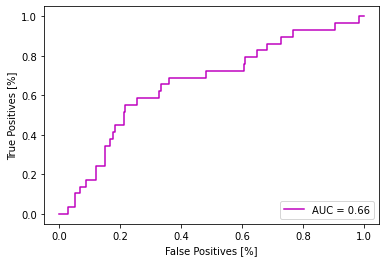

In [27]:

y_probs = prediction_probs[:, 0]
y_classes = prediction_classes[:, 0]
#print(y_probs)
#print(y_classes)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, y_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, y_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, y_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, y_classes)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(test_labels, y_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc_score = roc_auc_score(test_labels, y_probs)
print('ROC AUC score: %f' % auc_score)
# confusion matrix
print('Confusion_matrix:')
print('                    TrueP FalseN')
print('                    FalseP TrueN')
#labels must be specified as [1,0]. Without it, confusion_matrix 
#will report negative on the 1st row then positives on the 2nd row
#note: predictions are in columns and actual values in rows !!
matrix = confusion_matrix(test_labels, y_classes, labels=[1, 0])
print(matrix)
plot_roc(test_labels, prediction_probs)



In [30]:
print(y_probs)
print(prediction_probs)
print(y_classes)
print(prediction_classes)

[0.30889255 0.10922873 0.18535465 0.18623486 0.17393306 0.21511209
 0.20941314 0.12827617 0.29040653 0.14903489 0.2472792  0.28231272
 0.1521563  0.09117404 0.09885052 0.12708178 0.16107318 0.07221627
 0.20601472 0.26885712 0.20055494 0.07036692 0.13992187 0.13282612
 0.1042999  0.20467952 0.13525543 0.08746606 0.34588218 0.14966351
 0.13929296 0.14963087 0.19904244 0.17637393 0.11593115 0.2915681
 0.16631022 0.08400384 0.1717819  0.15759438 0.2712475  0.326767
 0.26185274 0.22604129 0.23236492 0.13696352 0.17530116 0.21822226
 0.2653554  0.14458305 0.25767666 0.21054372 0.25052953 0.19319484
 0.13775748 0.1584231  0.08680508 0.11415482 0.15019557 0.16668525
 0.16949967 0.13400316 0.12599942 0.19261312 0.103524   0.30557668
 0.10930634 0.32347563 0.1745112  0.29103488 0.23007458 0.19984382
 0.21303272 0.19585133 0.17796206 0.15694258 0.27678406 0.21455544
 0.2830068  0.14787757 0.13848147 0.15031025 0.3436528  0.11591738
 0.20356825 0.17457384 0.13037878 0.24793309 0.13748422 0.3511445